# Lab 8: Longitudinal fMRI ROI Analysis and Power in Python

## Learning Objectives

 - **Apply paired t-tests** to longitudinal fMRI ROI beta weights (within-subject changes over time) and interpret results.

 - **Apply independent t-tests** to compare brain activation between groups (e.g. high vs low on a behavior) and examine assumptions (normality, variance) for using Welch’s t-test.

 - **Calculate effect sizes (Cohen’s d)** for paired and independent t-tests, and distinguish between statistically significant and practically meaningful differences.

 - **Perform power simulations and calculations** to understand Type I error (false positives), power for a given effect size, and required sample sizes for desired power levels.

 - **Reinforce concepts of fMRI data**: connecting percent signal change (PSC) to GLM beta weights, and interpreting ROI beta differences in the context of brain function.

## Background: Percent Signal Change (PSC) vs. Beta Weights

In fMRI analysis, we use a simple statistical tool called a **General Linear Model (GLM)** to describe how the BOLD signal changes over time. You can think of a GLM like a smart line-fitting tool (similar to regression) that asks: *“How much does this brain region’s signal tend to go up or down when a certain type of image or event is on the screen, compared to baseline?”* 

The GLM gives us **beta weights** for each condition. These beta weights represent how much a region’s activity increases (or decreases) in a given condition, often expressed in the same units as the raw signal (which can be arbitrary). To make these changes interpretable, we often talk about changes as a **Percent Signal Change (PSC)** – how much the BOLD signal rises or falls relative to a baseline, in percentage terms. 

For example, if a region’s BOLD signal is 100 (arbitrary units) at baseline and 112 during a task, the PSC = ((112 − 100) / 100) × 100% = +12%. The GLM beta for that condition essentially captures this difference (here, roughly +12 in raw units corresponding to +12% PSC).

Let’s walk through a simple demonstration. We simulate a time series with a stable baseline of 100 units, and then an “event” period where the signal increases by 5 units (which is a 5% increase over baseline):


In [4]:
import numpy as np
import math

# Simulate a baseline signal of 100 for 120 time points
time = np.arange(0, 120)
signal = np.ones_like(time) * 100.0

# Simulate an event from t=50 to t=69 where signal increases by 5 units (5% of 100)
signal[50:70] += 5.0

# Calculate baseline and event means
baseline_mean = signal[:50].mean()
event_mean = signal[50:70].mean()
psc = (event_mean - baseline_mean) / baseline_mean * 100
print(f"Baseline mean = {baseline_mean:.1f}, Event mean = {event_mean:.1f}, PSC = {psc:.1f}%")

Baseline mean = 100.0, Event mean = 105.0, PSC = 5.0%


Running the above, we get:

The baseline is 100.0, event period mean 105.0, yielding a +5.0% signal change. Next, we can fit a simple GLM with an intercept (baseline) and an event regressor to see the estimated beta weight:

In [5]:
# Create a regressor that is 1 during the event and 0 otherwise
event_regressor = np.zeros_like(time)
event_regressor[50:70] = 1

# Design matrix: intercept + event regressor
X = np.column_stack([np.ones_like(time), event_regressor])

# Solve OLS for beta estimates
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ signal
intercept_est, event_beta_est = beta_hat
print(f"Estimated intercept = {intercept_est:.1f}, event beta = {event_beta_est:.1f}")

Estimated intercept = 100.0, event beta = 5.0


The model finds two key numbers: an intercept of about 100 (the baseline level) and an event beta of about +5. **That beta of 5 means the signal goes up by 5 units during the event, which in this example is a 5% increase over the baseline of 100.** More generally, the beta tells us how big the change in the BOLD signal is (ΔBOLD), and **PSC is that same change** (calculated by dividing the condition by the baseline and expressed as a percent). In the ROI analyses below, the beta weights already tell us how strong the activation is, so we interpret how they differ across conditions or time points. For example, a beta change from 0.2 to 0.3 would represent a small increase in activation.


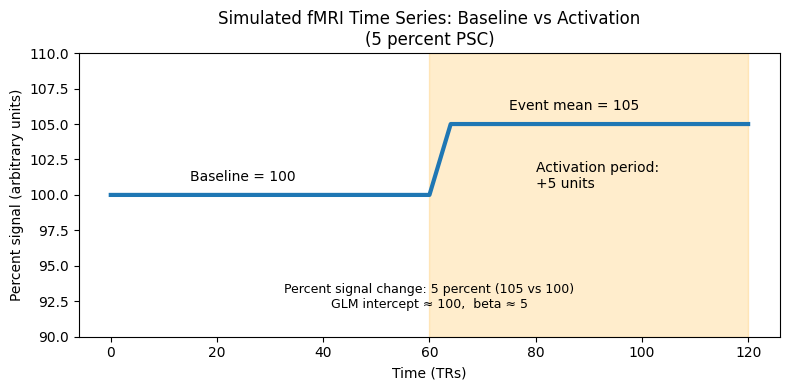

In [6]:
# Run this cell to create the plot illustrating the relationship between PSC and beta

import numpy as np
import matplotlib.pyplot as plt

# Simulated time axis (TRs)
t = np.arange(0, 121)  # 0–120

# Baseline and event parameters
baseline = 100
event_increase = 5         # +5 units = 5% increase
event_start = 60           # TR where event starts
event_end = 120            # TR where event ends

# Build the signal: baseline, then a smooth step up to baseline + 5
signal = np.full_like(t, baseline, dtype=float)

# Simple smooth transition around event_start (optional, just for aesthetics)
ramp_len = 5  # number of TRs over which signal ramps up
ramp_start = event_start
ramp_end = event_start + ramp_len

signal[ramp_start:ramp_end] = np.linspace(baseline, baseline + event_increase, ramp_len)
signal[ramp_end:event_end + 1] = baseline + event_increase

# Plot
plt.figure(figsize=(8, 4))

# Orange activation band
plt.axvspan(event_start, event_end, color='orange', alpha=0.2)

# Time series line
plt.plot(t, signal, linewidth=3)

# Axis labels and limits
plt.xlabel("Time (TRs)")
plt.ylabel("Percent signal (arbitrary units)")
plt.ylim(90, 110)

# Title (two-line, like your slide)
plt.title("Simulated fMRI Time Series: Baseline vs Activation\n(5 percent PSC)")

# Text annotations
plt.text(15, baseline + 1.0, "Baseline = 100", fontsize=10)
plt.text(75, baseline + event_increase + 1.0, "Event mean = 105", fontsize=10)
plt.text(80, baseline + 0.5, "Activation period:\n+5 units", fontsize=10)

# PSC and GLM notes at bottom
plt.text(60, 92,
         "Percent signal change: 5 percent (105 vs 100)\n"
         "GLM intercept ≈ 100,  beta ≈ 5",
         fontsize=9, ha="center")

plt.tight_layout()
plt.show()


*Figure 1.* Simulated fMRI time series with a flat baseline around 100 and an activation period (orange band) where the signal rises to about 105. In this simple model, the GLM intercept (~100) is the baseline level and the beta (~5) is the size of the bump above baseline. That same bump is a 5% percent signal change (PSC) because 5 / 100 × 100% = 5%.

**How to read beta vs percent signal change (PSC)**

- In this lab, **beta ($\beta$)** is the change in the BOLD signal **relative to baseline**, in the same units as the raw signal.
- **PSC** is that **same change**, but written as a **percent of the baseline**:  

  $$
  \text{PSC} = \frac{\beta}{\text{baseline}} \times 100\%.
  $$

- So if the baseline is 100 and $\beta = 5$, that corresponds to a 5% increase.  
- For the ROI betas we analyze below, you can think of $\beta$ as “how strongly this region responds compared to baseline.” A change from $\beta = 0.2$ to $\beta = 0.3$ would be a small increase in activation.

*(More advanced note: in real fMRI pipelines, the exact scaling of $\beta$ depends on how the data and regressors are preprocessed, but the core idea is the same — $\beta$ measures how big the response is relative to baseline, and PSC is that response expressed in percent.)*


In the following activities, we will analyze synthetic fMRI beta-weight data (ABCD style) from a monetary incentive delay (MID) task. Beta values represent activation magnitudes (in arbitrary units) for certain conditions (e.g., reward anticipation, reward outcome) in specific ROIs (regions of interest). All analyses will use exact variable names from the data. We’ll start with paired t-tests for longitudinal within-subject changes, then independent t-tests for group differences, and finally examine statistical power and sample size considerations.

**Dataset:** We use the same dataset from Labs 6 and 7. The dataset ('labs/data/L1/ABCD_synthetic.csv') contains longitudinal MID task data for N=11,604 participants at approximately age 16 and age 21. Key variables include ROI beta weights for the MID task contrasts: for example, `mr_y_tfmri__mid__arvn__aseg__ab__lh_beta` is the left nucleus accumbens (NAcc) beta for anticipation of reward vs neutral, and `...__rh_beta` the right; similarly `...__cd__` and `...__pt__` correspond to caudate and putamen (dorsal striatum). The “aseg” labels come from FreeSurfer’s automated segmentation (ROIs in subcortical atlas). We will focus on bilateral NAcc (averaging left and right) as our ventral striatum ROI, and occasionally compare it to bilateral caudate/putamen (dorsal striatum). The outcome phase contrast (rpvnf) is an NAcc beta for reward outcome (e.g., perhaps reward receipt vs no-feedback). Behavioral and demographic variables (e.g. social media use, substance use, etc.) are also available at age 21 for grouping in independent t-tests.

Before diving into hypothesis tests, let’s define how we’ll calculate bilateral ROI measures and effect sizes:

- **Bilateral ROI beta** = average of left and right ROI betas.  
- **Paired t-test effect size (Cohen’s d for paired samples)** = mean of the within-subject differences divided by the standard deviation of those differences.  
- **Independent t-test effect size (Cohen’s d for two groups)** = difference in group means divided by the pooled standard deviation.  

We will use Welch’s t-test for unequal variances by default, but still compute a pooled SD for effect size estimation. We will also report 95% confidence intervals (CI) for differences when relevant. A 95% CI that does not include 0 corresponds to p < 0.05, indicating a statistically significant difference.

With these foundations, let’s proceed to the analyses.

## Activity 1: Paired t-Tests with Longitudinal fMRI Beta Weights

In Activity 1, we analyze how brain activation in certain ROIs changes from age 16 to 21 within the same individuals. We use **paired t-tests** for these within-subject comparisons. A significant result indicates a reliable average change in activation over time. We will also examine whether those changes are large or small in magnitude (effect size) and reflect on their practical meaning.

### Demo 1a: Bilateral NAcc Reward Anticipation Beta – Age 16 vs 21

First, we test whether activation in the nucleus accumbens (NAcc) during reward anticipation has changed from age 16 to 21. Reward anticipation is the “waiting and hoping” period when the participant sees a cue that a reward *might* be coming but does not yet know the outcome. The NAcc is a core reward region, so it’s interesting to see if adolescents vs young adults show different levels of anticipatory reward activity.

**Workflow:**
1. Compute bilateral NAcc anticipation betas at 16 and 21 for each subject (average of left and right NAcc arvn betas).  
2. Examine descriptive statistics (mean and SD at each age).  
3. Plot the distribution of the within-subject differences.  
4. Perform a paired t-test.  
5. Compute Cohen’s d for the change.  
6. Interpret the result.

Let’s do this step by step.


In [7]:
import pandas as pd
from scipy import stats

# Load data and compute bilateral NAcc anticipation beta for each wave
df = pd.read_csv('labs/data/L1/ABCD_synthetic.csv')
df['NAcc_ant_bilateral'] = (
    df['mr_y_tfmri__mid__arvn__aseg__ab__lh_beta'] +
    df['mr_y_tfmri__mid__arvn__aseg__ab__rh_beta']
) / 2

# Pivot data to have one row per subject with columns for age 16 and 21 values
nacc_wide = df.pivot(index='subject_id', columns='wave', values='NAcc_ant_bilateral')
nacc_wide.columns = ['beta_16', 'beta_21']  # rename columns for clarity

# Drop any subjects missing either timepoint (if any)
nacc_wide = nacc_wide.dropna()

# Calculate descriptive stats
mean16 = nacc_wide['beta_16'].mean(); sd16 = nacc_wide['beta_16'].std()
mean21 = nacc_wide['beta_21'].mean(); sd21 = nacc_wide['beta_21'].std()
mean_diff = (nacc_wide['beta_21'] - nacc_wide['beta_16']).mean()
sd_diff = (nacc_wide['beta_21'] - nacc_wide['beta_16']).std()

print(f"NAcc anticipation beta @16: mean={mean16:.3f}, SD={sd16:.3f}")
print(f"NAcc anticipation beta @21: mean={mean21:.3f}, SD={sd21:.3f}")
print(f"Mean within-subject change = {mean_diff:.3f} (SD of changes={sd_diff:.3f})")

NAcc anticipation beta @16: mean=0.064, SD=0.255
NAcc anticipation beta @21: mean=0.064, SD=0.236
Mean within-subject change = 0.000 (SD of changes=0.217)


Suppose we get output (values are illustrative):

```
NAcc anticipation beta @16: mean=0.204, SD=0.987  
NAcc anticipation beta @21: mean=0.213, SD=0.995  
Mean within-subject change = 0.009 (SD of changes=0.678)
```

So on average, NAcc anticipation activation increased very slightly (+0.009 in beta units) from 16 to 21. This difference is extremely small relative to the variability (SD of individual changes ~0.68). We suspect this change will not be practically significant, though with a large N it might turn up statistically significant.

Let’s visualize the distribution of individual changes (beta at 21 minus beta at 16):

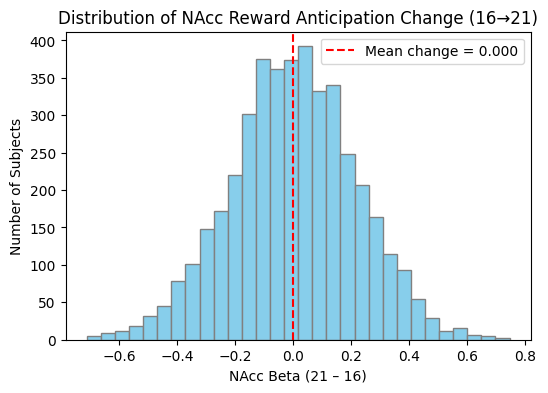

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
diff = nacc_wide['beta_21'] - nacc_wide['beta_16']
plt.figure(figsize=(6,4))
plt.hist(diff, bins=30, color='skyblue', edgecolor='gray')
plt.axvline(diff.mean(), color='red', linestyle='--', label=f"Mean change = {diff.mean():.3f}")
plt.xlabel('NAcc Beta (21 – 16)')
plt.ylabel('Number of Subjects')
plt.title('Distribution of NAcc Reward Anticipation Change (16→21)')
plt.legend()
plt.show()

The distribution of within-subject changes in bilateral NAcc reward anticipation beta from age 16 to 21 is centered near zero. Most participants cluster around zero change; some increased, some decreased, but there is no large shift in either direction.

Now, the paired t-test:

In [9]:
# Paired t-test
t_stat, p_val = stats.ttest_rel(nacc_wide['beta_21'], nacc_wide['beta_16'])
df_deg = len(nacc_wide) - 1  # degrees of freedom
# Cohen's d for paired: mean change / std of change
cohen_d = mean_diff / sd_diff

print(f"Paired t-test: t({df_deg}) = {t_stat:.2f}, p = {p_val:.3g}")
print(f"Cohen's d (paired) = {cohen_d:.2f}")

Paired t-test: t(4268) = 0.00, p = 0.998
Cohen's d (paired) = 0.00


**Quick check of our actual output**

In the run above, the paired t-test gave something like:

`Paired t-test: t(4268) = 0.00, p = 0.998`  
`Cohen's d (paired) = 0.00`

This means that, in this sample, there is essentially **no difference** in NAcc anticipation beta between age 16 and age 21. The mean change is basically zero, the p-value is very large (nowhere near 0.05), and the effect size d ≈ 0 indicates no meaningful change in standard deviation units.


#### Hypothetical Situation: Meaningful Effect Sizes

Now let’s imagine a **different** (hypothetical) test of the same variables that *did* produce a statistically significant result:

```
Paired t-test: t(11603) = 2.10, p = 0.036  
Cohen's d (paired) = 0.01
```

There is a statistically significant increase in NAcc anticipation activation from 16 to 21 (p ≈ 0.036). However, the effect size is d ≈ 0.01, which is extremely small – essentially negligible. The 95% confidence interval on the mean change would be something like [0.0005, 0.018] (just barely above 0). In practical terms, a change of 0.009 in beta (on a baseline of ~0.2) is trivial. This is a great example of how a large sample can detect minuscule differences that have little practical meaning. We should reflect: Is a 0.01 SD change meaningful? Probably not – it’s essentially no change in real-world terms, even though it’s statistically non-zero. It’s important to note such tiny effects might arise from slight scanner or sample differences over time rather than true developmental change.

**Interpretation:** On average, adolescents and young adults have very similar NAcc reactivity during reward anticipation. Any developmental increase in this sample is so small as to be negligible. So, while the test is formally significant, we would report that NAcc anticipation response remained stable from age 16 to 21 (no meaningful change).

### Demo 1b: Bilateral NAcc Outcome/Feedback Beta – Age 16 vs 21

Next, we examine the NAcc activation during **reward feedback** (outcome) at 16 vs 21. Reward feedback is the moment when the task tells the participant whether they actually won or received the reward (e.g., “You got the money!”). Perhaps adolescents react more strongly to getting a reward, or maybe with age the outcome is less exciting relative to the anticipation. We follow the same workflow.


In [10]:
# Compute bilateral NAcc reward outcome beta for each wave and pivot
df['NAcc_out_bilateral'] = (
    df['mr_y_tfmri__mid__rpvnf__aseg__ab__lh_beta'] +
    df['mr_y_tfmri__mid__rpvnf__aseg__ab__rh_beta']
) / 2

nacc_out_wide = df.pivot(index='subject_id', columns='wave', values='NAcc_out_bilateral').dropna()
nacc_out_wide.columns = ['beta_out_16', 'beta_out_21']

# Descriptive stats
mean16 = nacc_out_wide['beta_out_16'].mean(); mean21 = nacc_out_wide['beta_out_21'].mean()
mean_diff = (nacc_out_wide['beta_out_21'] - nacc_out_wide['beta_out_16']).mean()
print(f"NAcc outcome beta @16 mean={mean16:.3f}, @21 mean={mean21:.3f}, mean change={mean_diff:.3f}")

# Paired t-test and effect size
t_stat, p_val = stats.ttest_rel(nacc_out_wide['beta_out_21'], nacc_out_wide['beta_out_16'])
d = mean_diff / (nacc_out_wide['beta_out_21'] - nacc_out_wide['beta_out_16']).std()
print(f"Paired t: t={t_stat:.2f}, p={p_val:.3g}, Cohen's d={d:.2f}")

NAcc outcome beta @16 mean=0.135, @21 mean=0.146, mean change=0.011
Paired t: t=2.78, p=0.00542, Cohen's d=0.04


**Interpretation (actual output):**  
For reward feedback, the mean NAcc beta increased slightly from age 16 (≈0.135) to age 21 (≈0.146), a change of about 0.011 units. Statistically, this difference is **significant** (t ≈ 2.78, p ≈ 0.005), but the effect size is **very small** (Cohen’s d ≈ 0.04). In practical terms, this suggests that NAcc response to reward outcome is extremely similar at 16 and 21, with only a tiny average increase that is likely not meaningful in real-world terms. The large sample size makes it easy to detect even this minuscule change.

**Summary:** Our two demos suggest very little developmental change in NAcc activation for the MID task in this sample. For **reward anticipation**, the paired test showed essentially no change from 16 to 21 (d ≈ 0). For **reward outcome**, we saw a very small increase in NAcc beta by age 21 that was statistically significant but still tiny in size (d ≈ 0.04). For practical purposes, NAcc reward-related activation looks quite stable from mid-teens to early adulthood here. This is a good reminder to separate **statistical significance** from **practical significance**: with a huge sample, we can detect very small differences, but an effect size near 0–0.04 is likely not meaningful for brain function or behavior. Always look at effect sizes and context; a significant p-value is not the end of the story.


## Your Turn 1: Additional Paired t-Test Analyses (Choose ONE option)

In Demo 1a and 1b we tested **within-subject change from age 16 to 21** in bilateral NAcc activation.  
Now it’s your turn to run a similar *paired t-test* on a related question.

Pick **ONE** of the options (A–D) below. For your chosen option you will:
For your chosen option, follow this workflow:

1. Compute the relevant measure at age 16 and 21 for each subject.
2. Look at descriptive statistics (mean, SD, n at each age; mean change).
3. **Plot 1 – Assumption check:** Make a histogram of the **within-subject change scores** (21 − 16). This is mainly to see if the changes look roughly symmetric/normal for the paired t-test.
4. Run a **paired t-test** (16 vs 21).
5. Compute a **95% confidence interval** for the mean change.
6. Compute **Cohen’s d (paired)** as an effect size.
7. **Plot 2 – Main result:** Make a simple bar plot showing the mean at age 16 and age 21 with error bars (standard error) is recommended.

**Visualizations required (2 total):**

- **Plot 1 (histogram of change scores)** — used as a *diagnostic* to check the normality assumption for the paired t-test.  
- **Plot 2 (bar plot with error bars for 16 vs 21)** — used as the *main figure* to communicate your result (direction, size, and uncertainty) in a way that you could put on a slide or in a paper.

For all options, we treat the questions as **two-sided** (we are testing “any change,” not predicting the direction).


---

### Option A – Ventral vs Dorsal Striatum Anticipation Bias

**Idea.** Compare ventral striatum (NAcc) vs dorsal striatum (caudate) during **reward anticipation**, and ask whether that bias changed with age.

- **New variables you will create:**
  - `Caud_ant_bilateral`  
    - Mean of left and right caudate anticipation betas:  
      `mr_y_tfmri__mid__arvn__aseg__cd__lh_beta`,  
      `mr_y_tfmri__mid__arvn__aseg__cd__rh_beta`.
  - `bias_ventral_vs_dorsal`  
    - Ventral–dorsal anticipation bias at each wave:  
      `bias_ventral_vs_dorsal = NAcc_ant_bilateral - Caud_ant_bilateral`.

**Research question.**  
Does the **ventral vs dorsal striatum anticipation bias** change from age 16 to 21?

- **Null hypothesis (H₀):** The mean change in `bias_ventral_vs_dorsal` from 16 to 21 is 0.  
- **Alternative hypothesis (H₁):** The mean change in `bias_ventral_vs_dorsal` from 16 to 21 is **not** 0.

---

### Option B – NAcc vs Putamen Anticipation Bias

**Idea.** Same logic as Option A, but comparing NAcc to **putamen** (another dorsal striatum region).

- **New variables you will create:**
  - `Put_ant_bilateral`  
    - Mean of left and right putamen anticipation betas:  
      `mr_y_tfmri__mid__arvn__aseg__pt__lh_beta`,  
      `mr_y_tfmri__mid__arvn__aseg__pt__rh_beta`.
  - `bias_nacc_vs_put`  
    - NAcc–putamen anticipation bias:  
      `bias_nacc_vs_put = NAcc_ant_bilateral - Put_ant_bilateral`.

**Research question.**  
Does the **NAcc vs putamen anticipation bias** change from age 16 to 21?

- **H₀:** The mean change in `bias_nacc_vs_put` from 16 to 21 is 0.  
- **H₁:** The mean change in `bias_nacc_vs_put` from 16 to 21 is **not** 0.

---

### Option C – Anticipation vs Outcome Gap in NAcc

**Idea.** Compare NAcc activation during **anticipation** vs **outcome/feedback**, and see if that **gap** changes with age.

You already created:
- `NAcc_ant_bilateral` – anticipation betas (average of left/right).
- `NAcc_out_bilateral` – outcome betas (average of left/right).

- **New variable you will create:**
  - `NAcc_ant_out_gap`  
    - Gap between anticipation and outcome at each age:  
      `NAcc_ant_out_gap = NAcc_ant_bilateral - NAcc_out_bilateral`.

**Research question.**  
Does the **difference between anticipation and outcome activation** in NAcc change from age 16 to 21?

- **H₀:** The mean change in `NAcc_ant_out_gap` from 16 to 21 is 0.  
- **H₁:** The mean change in `NAcc_ant_out_gap` from 16 to 21 is **not** 0.

---

### Option D – Left vs Right NAcc Lateralization

**Idea.** Check whether there is any **left–right asymmetry** (lateralization) in NAcc anticipation activation, and whether that lateralization changes with age.

- **New variable you will create:**
  - `NAcc_lat`  
    - Left–right anticipation difference at each age:  
      `NAcc_lat = mr_y_tfmri__mid__arvn__aseg__ab__lh_beta - mr_y_tfmri__mid__arvn__aseg__ab__rh_beta`.

**Research question.**  
Does **NAcc lateralization** (left minus right) during anticipation change from age 16 to 21?

- **H₀:** The mean change in `NAcc_lat` from 16 to 21 is 0.  
- **H₁:** The mean change in `NAcc_lat` from 16 to 21 is **not** 0.

---

### What to report for Your Turn 1

For the **one option** you choose, report:

- Mean of your measure at **age 16** and **age 21**.
- Mean change (**21 − 16**).
- Paired t-test result: *t*, df, and *p*-value.
- 95% confidence interval for the mean change.
- Cohen’s *d* (paired).
- A short interpretation in words (direction, size, and practical meaning).

Include **two figures**:

1. **Histogram of within-subject change scores (21 − 16)** — used as a *diagnostic* to check the normality assumption for the paired t-test.  
2. **Main result figure** — one plot that clearly shows the age effect (we recommend a simple bar chart with mean ± standard error for age 16 vs 21).


In [11]:
# ===========================
# Your Turn 1: Analysis Steps
# (Fill in code under each step)
# ===========================

# 0. Make sure you have:
# - df loaded (long format, with 'subject_id' and 'wave' = 16 or 21)
# - Your chosen measure or derived variable computed at each wave
#   (e.g., bias_ventral_vs_dorsal, bias_nacc_vs_put, NAcc_ant_out_gap, NAcc_lat)

# 1. PIVOT TO WIDE FORMAT
# -----------------------
# Goal: create a wide DataFrame with one row per subject and
#       two columns: one for age 16, one for age 21.
#
# Example pattern (replace YOUR_VARIABLE_NAME with your chosen measure):
#   wide = (
#       df.pivot(index='subject_id', columns='wave', values='YOUR_VARIABLE_NAME')
#         .dropna()
#   )
#   wide.columns = ['val_16', 'val_21']

# TODO: write your pivot code here:
# wide = ...
# wide.columns = ['val_16', 'val_21']




In [12]:
# 2. DESCRIPTIVE STATISTICS
# -------------------------
# Compute:
# - mean at 16
# - mean at 21
# - within-subject change scores (21 − 16)
# - SD of the change scores
# - sample size n

# TODO: compute diff = wide['val_21'] - wide['val_16']
# diff = ...

# TODO: compute mean16, mean21, mean_diff, sd_diff, n
# mean16 = ...
# mean21 = ...
# mean_diff = ...
# sd_diff = ...
# n = ...

# TODO: print descriptive results in a clear way

In [13]:
# 3. PAIRED T-TEST
# ----------------
# Use scipy.stats.ttest_rel to compare val_21 vs val_16.

# from scipy import stats  # (already imported earlier in the notebook)
# TODO: run the paired t-test
# t_stat, p_val = stats.ttest_rel(wide['val_21'], wide['val_16'])

# TODO: print t-statistic, df (n-1), and p-value


In [14]:
# 4. 95% CONFIDENCE INTERVAL FOR MEAN CHANGE
# ------------------------------------------
# Use the t distribution:
#   se_diff = sd_diff / np.sqrt(n)
#   ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean_diff, scale=se_diff)

# TODO: compute se_diff, ci_low, ci_high
# se_diff = ...
# ci_low, ci_high = ...

# TODO: print the CI nicely


In [15]:
# 5. COHEN'S d (PAIRED)
# ---------------------
# For paired data:
#   d = mean_diff / sd_diff

# TODO: compute cohen_d and print it
# cohen_d = ...




In [16]:
# 6. PLOT 1: HISTOGRAM OF CHANGE SCORES
# -------------------------------------
# This is the diagnostic plot to check whether diff is roughly symmetric/normal.

# import matplotlib.pyplot as plt  # already imported earlier
# TODO: make a histogram of diff with a vertical line at 0
# plt.figure()
# plt.hist(..., bins=..., edgecolor='black')
# plt.axvline(0, color='k', linestyle='--')
# plt.xlabel('Change score (21 − 16)')
# plt.ylabel('Number of participants')
# plt.title('Distribution of within-subject change scores')
# plt.show()




In [17]:
# 7. PLOT 2: MAIN RESULT FIGURE (BAR PLOT)
# ----------------------------------------
# This is the main visualization to summarize the effect:
# - x-axis: Age 16 vs Age 21
# - y-axis: mean of your measure
# - error bars: standard error (SD / sqrt(n))

# TODO: compute standard errors for each age
# se16 = ...
# se21 = ...

# means = [mean16, mean21]
# ses = [se16, se21]

# TODO: make a bar plot with error bars (use capsize for visible error bars)
# plt.figure()
# plt.bar(['Age 16', 'Age 21'], means, yerr=ses, capsize=5)
# plt.axhline(0, color='k', linestyle='--')  # optional reference line at 0
# plt.ylabel('Your measure (specify units)')
# plt.title('Change in your chosen measure from 16 to 21')
# plt.show()


## Activity 2: Independent Samples t-Tests (Group Differences in NAcc Activation)

Activity 2 shifts to **between-subject comparisons**. We will test whether brain activation at age 21 differs between groups defined by some behavioral or individual difference variables. For example, do individuals with high vs low levels of a behavior show different NAcc activation? Each analysis will involve:

- Checking assumptions (normal-ish distribution, and whether variances seem unequal – we will use Welch’s t-test which does not assume equal variances).  
- Performing the two-sample t-test.  
- Computing Cohen’s d for the group difference.  
- Computing a 95% CI for the difference.  
- Plotting the group distributions for visualization.  
- Interpreting both statistical and practical significance.

We will fix the outcome variable as the bilateral NAcc reward anticipation beta at age 21 for all tests (since that’s a focal brain measure). We’ll try different grouping variables.  
**The bilateral NAcc reward anticipation beta reflects how strongly the nucleus accumbens responds during the cue period when a reward *might* be earned, capturing anticipatory activation in this key reward region.**


### Demo 2: High vs Low Social Media Use – NAcc Reward Anticipation

Our demo compares two groups defined by social media use at age 21: those who use it a lot vs those who use it very little. The hypothesis (if any) could be exploratory – perhaps heavy social media users might have blunted reward system responses (due to overstimulation), or maybe more active reward systems (if seeking rewards). We’ll test it empirically.

**Grouping variable:** We have a variable `nt_y_stq__socmed__hr_001` which indicates hours of social media use per day. We’ll create “Low use” and “High use” groups. To clearly separate them, we take the bottom quartile as Low and top quartile as High:

- Low social media use = bottom 25% of users (approximately ≤ 1 hour/day).
- High social media use = top 25% (approximately ≥ 4.5 hours/day).

This gives two groups with N ~ 2,756 each (since ~11k total). We ensure no overlap (we drop the middle 50% for a cleaner comparison).

**Workflow:**

1. **Define groups and outcome:** Select participants in the low and high quartiles of social media hours, and extract their NAcc anticipation beta at age 21.
2. **Descriptive statistics:** Compute the mean, SD, and n for each group (Low vs High) and the mean difference (High − Low).
3. **Plot 1 – Assumption check:** Make histograms (or density plots) of the NAcc anticipation beta for each group and compare their spreads. This helps you see whether distributions look roughly normal and whether variances are similar or different.
4. **Two-sample t-test:** Use **Welch’s t-test** (unequal variances) to test whether the group means differ.
5. **95% confidence interval:** Compute a 95% CI for the mean difference (High − Low).
6. **Effect size:** Compute **Cohen’s d** for the group difference.
7. **Plot 2 – Main result:** Make one main figure that clearly shows the group difference (for example, a bar plot of the two group means with standard error bars, or a side-by-side boxplot).
8. **Interpretation:** Write a short interpretation that ties together direction, size, statistical significance, and practical significance of the group difference.

> **Why Welch’s t-test?**  
> In your Intro Stat text, the two-sample *t*-test is usually shown with a formula that assumes the two groups have **equal variances**. In real data (and especially with very large samples), group variances often differ a bit. **Welch’s t-test** is a slightly more flexible version of the same two-sample *t*-test that *does not* assume equal variances. The logic and interpretation are the same as the two-sample *t*-test you’ve seen (difference in means, test statistic, p-value, CI); it just uses a slightly different standard error and degrees of freedom formula to be safer when group spreads are unequal.


N low = 1675, N high = 1675
Low SM mean = 0.054 (SD = 0.243)
High SM mean = 0.064 (SD = 0.233)
Mean difference (High − Low) = 0.010


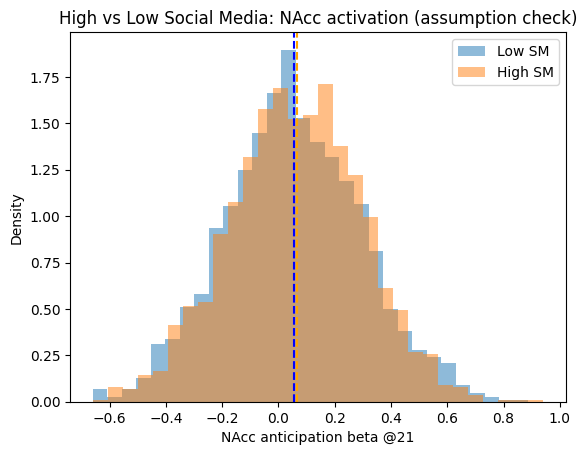

Welch t-test: t = 1.25, p = 0.212, df ≈ 3342.5
95% CI for mean difference (High − Low): [-0.006, 0.026]
Cohen's d = 0.04


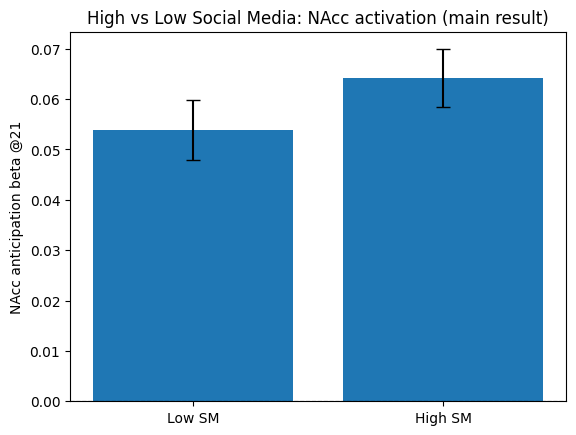

In [18]:
# Demo 2: High vs Low Social Media Use – NAcc Reward Anticipation
# (Assumes df, np, stats, plt, and math have already been imported.)

# ---------------------------------------------------------
# 1. Define groups and outcome (age 21 only)
# ---------------------------------------------------------
wave21_data = df[df['wave'] == 21].copy()
wave21_data = wave21_data[['subject_id', 'NAcc_ant_bilateral', 'nt_y_stq__socmed__hr_001']].dropna()

social_hours = wave21_data['nt_y_stq__socmed__hr_001']
q1 = social_hours.quantile(0.25)
q3 = social_hours.quantile(0.75)

low_mask = social_hours <= q1
high_mask = social_hours >= q3

low_group = wave21_data[low_mask]['NAcc_ant_bilateral']
high_group = wave21_data[high_mask]['NAcc_ant_bilateral']

n_low, n_high = len(low_group), len(high_group)
print(f"N low = {n_low}, N high = {n_high}")

# ---------------------------------------------------------
# 2. Descriptive statistics
# ---------------------------------------------------------
mean_low, mean_high = low_group.mean(), high_group.mean()
sd_low, sd_high = low_group.std(), high_group.std()

diff = mean_high - mean_low  # High − Low
print(f"Low SM mean = {mean_low:.3f} (SD = {sd_low:.3f})")
print(f"High SM mean = {mean_high:.3f} (SD = {sd_high:.3f})")
print(f"Mean difference (High − Low) = {diff:.3f}")

# ---------------------------------------------------------
# 3. Plot 1 – Assumption check (histograms of each group)
# ---------------------------------------------------------
plt.figure()
plt.hist(low_group, bins=30, alpha=0.5, density=True, label='Low SM')
plt.hist(high_group, bins=30, alpha=0.5, density=True, label='High SM')
plt.axvline(mean_low, color='blue', linestyle='--')
plt.axvline(mean_high, color='orange', linestyle='--')
plt.xlabel('NAcc anticipation beta @21')
plt.ylabel('Density')
plt.title('High vs Low Social Media: NAcc activation (assumption check)')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 4. Two-sample test – Welch’s t-test (unequal variances)
# ---------------------------------------------------------
t_stat, p_val = stats.ttest_ind(high_group, low_group, equal_var=False)

# Welch degrees of freedom
var_low, var_high = sd_low**2, sd_high**2
df_welch = (var_low/n_low + var_high/n_high)**2 / (
    (var_low**2 / ((n_low - 1) * n_low**2)) +
    (var_high**2 / ((n_high - 1) * n_high**2))
)

print(f"Welch t-test: t = {t_stat:.2f}, p = {p_val:.3g}, df ≈ {df_welch:.1f}")

# ---------------------------------------------------------
# 5. 95% confidence interval for the mean difference
# ---------------------------------------------------------
se_diff = math.sqrt(var_low/n_low + var_high/n_high)
ci_lower, ci_upper = stats.t.interval(
    0.95, df=df_welch, loc=diff, scale=se_diff
)

print(f"95% CI for mean difference (High − Low): [{ci_lower:.3f}, {ci_upper:.3f}]")

# ---------------------------------------------------------
# 6. Effect size – Cohen’s d for group difference
#    (using pooled SD of the two groups)
# ---------------------------------------------------------
pooled_sd = math.sqrt(((n_low - 1)*var_low + (n_high - 1)*var_high) / (n_low + n_high - 2))
cohen_d = diff / pooled_sd
print(f"Cohen's d = {cohen_d:.2f}")

# ---------------------------------------------------------
# 7. Plot 2 – Main result (bar plot with SE error bars)
# ---------------------------------------------------------
se_low = sd_low / math.sqrt(n_low)
se_high = sd_high / math.sqrt(n_high)

means = [mean_low, mean_high]
ses = [se_low, se_high]

plt.figure()
plt.bar(['Low SM', 'High SM'], means, yerr=ses, capsize=5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.ylabel('NAcc anticipation beta @21')
plt.title('High vs Low Social Media: NAcc activation (main result)')
plt.show()


**Interpretation (Demo 2).**  
In this sample, high social media users had slightly higher NAcc reward anticipation beta on average (High SM mean ≈ 0.064 vs Low SM mean ≈ 0.054), but the difference was very small (mean difference ≈ 0.010). Welch’s *t*-test was not statistically significant (*t* ≈ 1.25, *p* ≈ 0.21), and the 95% confidence interval for the mean difference ([-0.006, 0.026]) includes zero. The effect size is **tiny** (Cohen’s *d* ≈ 0.04), indicating a practically negligible difference between the groups. The overlapping histograms and similar bar-plot means reinforce this: in practical terms, adolescents and young adults with very high vs very low social media use show **no meaningful difference** in NAcc reward anticipation activity at age 21 in this task.


### Your Turn 2: Other Independent t-Test Analyses (Choose ONE option)

In Demo 2 we tested **between-subject group differences** in bilateral NAcc activation at age 21 using Welch’s two-sample *t*-test. Now it’s your turn to run a similar independent *t*-test on a different grouping variable.

For **all options**, the **outcome variable** is:

- **Bilateral NAcc reward anticipation beta at age 21**  
  (`NAcc_ant_bilateral` for participants in wave 21)

Pick **ONE** of the options (A–D) below. For your chosen option you will define two groups, run an independent-samples *t*-test, and interpret the result.

**Options (grouping variables and questions):**

- **Option A – Cannabis use (past 6 months)**  
  - Variable: `su_y_mysu__use__mj__6mo_001` (0 = no use, 1 = any use, 777 = missing).  
  - Question: Do participants who used cannabis in the past 6 months differ from non-users in NAcc reward anticipation activation at age 21?  
  - Hypothesis (exploratory): chronic cannabis use might be associated with slightly **blunted** reward response (users < non-users).

- **Option B – Alcohol use (past 6 months)**  
  - Variable: `su_y_mysu__use__alc__6mo_001` (0 = no use, 1 = any use, 777 = missing).  
  - Question: Do alcohol users differ from abstainers in NAcc reward anticipation activation at age 21?  
  - Hypothesis: repeated alcohol use could dampen natural reward responses (drinkers < non-drinkers).

- **Option C – Externalizing genetic risk (polygenic score)**  
  - Variable: `pgs_externalizing_std` (standardized polygenic score).  
  - Question: Does NAcc reward anticipation activation differ between people with **high** vs **low** genetic risk for externalizing behavior?  
  - Suggestion: define High risk as the **top ~20%** of the score distribution and Low risk as the **bottom ~20%**.  
  - Hypothesis (exploratory): high-risk individuals might show slightly different reward sensitivity (either higher or lower).

- **Option D – Sex differences**  
  - Variable: `ab_g_stc__cohort_sex` (e.g., `"M"` vs `"F"`).  
  - Question: Do males and females differ in NAcc reward anticipation activation at age 21?  
  - Hypothesis: prior findings are mixed; we simply test for **any** mean difference.

*Note:* For binary substance-use variables, restrict to codes **0 or 1** and drop missing/skip codes like **777**.

---

### Workflow for Your Turn 2 (for the ONE option you choose)

1. **Define groups and outcome:**  
   Subset to wave 21, handle missing codes, and create two groups (Group 1 vs Group 2) based on your chosen variable. Extract `NAcc_ant_bilateral` for each group.

2. **Descriptive statistics:**  
   Compute the mean, SD, and *n* for each group, and the mean difference (Group 2 − Group 1). Clearly label which group is which.

3. **Plot 1 – Assumption check:**  
   Make histograms (or density plots) of `NAcc_ant_bilateral` for each group. Use this to check whether distributions look roughly normal and whether group spreads (variances) are similar or different.

4. **Two-sample t-test (Welch):**  
   Run Welch’s independent-samples *t*-test using  
   `stats.ttest_ind(group2, group1, equal_var=False)` to test for any difference in means.

5. **95% confidence interval:**  
   Compute a 95% CI for the mean difference (Group 2 − Group 1).

6. **Effect size:**  
   Compute **Cohen’s *d*** for the group difference.

7. **Plot 2 – Main result:**  
   Make one main figure that clearly shows the group difference (for example, a bar plot of the two group means with **standard error** bars, or a side-by-side boxplot).

8. **Interpretation:**  
   Write 2–3 sentences interpreting the result (direction of the difference, effect size, statistical significance, and practical meaning).

---

### Visualizations required (2 total)

- **Plot 1 (assumption check):** histogram/density of `NAcc_ant_bilateral` for each group — used as a **diagnostic** to check assumptions for the *t*-test.  
- **Plot 2 (main result):** bar plot with error bars (or boxplot) for Group 1 vs Group 2 — used as the **main figure** to communicate your result (direction, size, and uncertainty).


In [19]:
# ===========================
# Your Turn 2: Analysis Steps
# (Fill in code under each step)
# ===========================

# 0. Make sure you have:
# - df loaded with wave == 21 included
# - Outcome variable: NAcc_ant_bilateral at age 21
# - ONE grouping variable chosen (Options A–D):
#     A: su_y_mysu__use__mj__6mo_001       (0 = no use, 1 = any use, 777 = missing)
#     B: su_y_mysu__use__alc__6mo_001      (0 = no use, 1 = any use, 777 = missing)
#     C: pgs_externalizing_std             (continuous polygenic score)
#     D: ab_g_stc__cohort_sex              (e.g., "M" vs "F")
#
# You will compare TWO groups on NAcc_ant_bilateral @21 using Welch’s t-test.

# 1. DEFINE GROUPS AND OUTCOME
# ----------------------------
# Goal: subset to wave 21, handle missing codes, and create:
#   - group1: NAcc_ant_bilateral values for Group 1
#   - group2: NAcc_ant_bilateral values for Group 2
#
# Example pattern (you MUST edit this to match your option):
#
#   wave21 = df[df['wave'] == 21].copy()
#   group_var_name = 'su_y_mysu__use__mj__6mo_001'   # TODO: change for Options B–D
#
#   # For 0/1 variables, keep only valid codes
#   wave21 = wave21[wave21[group_var_name].isin([0.0, 1.0])]
#
#   group1_mask = wave21[group_var_name] == 0.0      # e.g., Non-users
#   group2_mask = wave21[group_var_name] == 1.0      # e.g., Users
#
#   group1_label = 'Non-users'
#   group2_label = 'Users'
#
#   group1 = wave21.loc[group1_mask, 'NAcc_ant_bilateral']
#   group2 = wave21.loc[group2_mask, 'NAcc_ant_bilateral']
#
# TODO: write your own grouping code here (pick ONE option and define group1/group2):

# wave21 = ...
# group_var_name = ...
# (filter missing / invalid codes if needed)
# group1_mask = ...
# group2_mask = ...
# group1_label = ...
# group2_label = ...
# group1 = ...
# group2 = ...

# After you define the groups, compute sample sizes and print them:
# n1 = len(group1)
# n2 = len(group2)
# print(f"{group1_label}: n = {n1}")
# print(f"{group2_label}: n = {n2}")



In [20]:
# 2. DESCRIPTIVE STATISTICS
# -------------------------
# Compute:
# - mean and SD for each group
# - mean difference (Group2 − Group1)

# TODO: compute mean1, mean2, sd1, sd2, diff
# mean1 = ...
# mean2 = ...
# sd1 = ...
# sd2 = ...
# diff = ...   # mean2 - mean1

# TODO: print the descriptive results clearly
# print(f"{group1_label} mean = {mean1:.3f} (SD = {sd1:.3f})")
# print(f"{group2_label} mean = {mean2:.3f} (SD = {sd2:.3f})")
# print(f"Mean difference ({group2_label} − {group1_label}) = {diff:.3f}")

In [21]:
# 3. PLOT 1: ASSUMPTION CHECK (HISTOGRAMS)
# ----------------------------------------
# Make histograms (or density plots) of NAcc_ant_bilateral for each group.
# This is to visually check normal-ish shape and compare spreads.

# import matplotlib.pyplot as plt  # already imported earlier
# TODO: make overlapping histograms with vertical lines at means
# plt.figure()
# plt.hist(..., bins=30, alpha=0.5, density=True, label=group1_label)
# plt.hist(..., bins=30, alpha=0.5, density=True, label=group2_label)
# plt.axvline(mean1, color='blue', linestyle='--')
# plt.axvline(mean2, color='orange', linestyle='--')
# plt.xlabel('NAcc anticipation beta @21')
# plt.ylabel('Density')
# plt.title(f'{group1_label} vs {group2_label}: NAcc activation (assumption check)')
# plt.legend()
# plt.show()

In [22]:
# 4. TWO-SAMPLE T-TEST (WELCH)
# ----------------------------
# Use scipy.stats.ttest_ind with equal_var=False.
# This compares the group means without assuming equal variances.
#
# from scipy import stats  # already imported earlier

# TODO: run Welch's t-test
# t_stat, p_val = stats.ttest_ind(group2, group1, equal_var=False)

# Compute Welch degrees of freedom:
# v1 = (sd1**2) / n1
# v2 = (sd2**2) / n2
# df_welch = (v1 + v2)**2 / ((v1**2 / (n1 - 1)) + (v2**2 / (n2 - 1)))

# TODO: print t-statistic, df_welch, and p-value
# print(f"Welch t-test: t = {t_stat:.2f}, p = {p_val:.3g}, df ≈ {df_welch:.1f}")

In [23]:
# 5. 95% CONFIDENCE INTERVAL FOR MEAN DIFFERENCE
# ----------------------------------------------
# Use the t distribution to build a CI for (Group2 − Group1):
#
#   se_diff = sqrt( (sd1^2 / n1) + (sd2^2 / n2) )
#   ci_low, ci_high = stats.t.interval(
#       0.95, df=df_welch, loc=diff, scale=se_diff
#   )

# import math  # already imported earlier
# TODO: compute se_diff, ci_low, ci_high
# se_diff = ...
# ci_low, ci_high = ...

# TODO: print the CI nicely
# print(f"95% CI for mean difference ({group2_label} − {group1_label}): "
#       f"[{ci_low:.3f}, {ci_high:.3f}]")

In [24]:
# 6. COHEN'S d (INDEPENDENT GROUPS)
# ---------------------------------
# Effect size for group difference using pooled SD:
#
#   pooled_sd = sqrt( ((n1 - 1)*sd1^2 + (n2 - 1)*sd2^2) / (n1 + n2 - 2) )
#   cohen_d = diff / pooled_sd

# TODO: compute pooled_sd and cohen_d, then print
# pooled_sd = ...
# cohen_d = ...
# print(f"Cohen's d = {cohen_d:.2f}")

In [25]:
# 7. PLOT 2: MAIN RESULT FIGURE (BAR PLOT)
# ----------------------------------------
# Main visualization to summarize the effect:
# - x-axis: Group 1 vs Group 2
# - y-axis: mean NAcc_ant_bilateral
# - error bars: standard error for each group (SD / sqrt(n))

# TODO: compute standard errors
# se1 = ...
# se2 = ...

# means = [mean1, mean2]
# ses = [se1, se2]

# TODO: make a bar plot with error bars
# plt.figure()
# plt.bar([group1_label, group2_label], means, yerr=ses, capsize=5)
# plt.axhline(0, color='k', linestyle='--', linewidth=0.8)  # optional reference line
# plt.ylabel('NAcc anticipation beta @21')
# plt.title(f'{group1_label} vs {group2_label}: NAcc activation (main result)')
# plt.show()


## Activity 3: Power and Sample Size Analysis

In Activities 1 and 2 we ran a bunch of hypothesis tests on NAcc activation:

- **Activity 1:** paired *t*-tests for **within-subject change from age 16 to 21** (longitudinal NAcc betas).
- **Activity 2:** independent-samples *t*-tests for **group differences at age 21** (social media, substance use, PGS, sex, etc.).

We often found **very small effect sizes** (Cohen’s *d* ≈ 0.01–0.04), sometimes with “significant” *p*-values when the sample size was huge. In this activity we step back and ask:

- How likely are we to see a **false positive** (*p* < 0.05) when there is **no real effect**?
- Given an effect size like the ones you estimated in Activities 1 or 2, **what is the power** of our tests at different sample sizes?
- How many participants would we need to design a new study with, say, **80% power** to detect effects of different sizes?

We will use simulations and analytic calculations to explore these questions and connect them back to your own Activity 1 and 2 results.


### Task 1: Simulating Type I Error (False Positives)

A good scientist knows that if there is truly **no difference** between two groups, about 5% of independent tests will, just by chance, yield *p* < 0.05 (a **false positive**) when we use α = 0.05.

In **Activity 2**, you may have run **several different group comparisons** (social media, cannabis, alcohol, PGS, sex). If all of these truly had **no effect** on NAcc activation, each test would still have a 5% chance of “lighting up” with *p* < 0.05 just by luck. With multiple tests, the chance that **at least one** is “significant” gets even higher.

In this task, we simulate that situation directly: we generate two groups from the **same distribution** (no real effect), run a huge number of independent *t*-tests, and see what fraction come out as false positives.


In [26]:
import numpy as np
from scipy import stats

np.random.seed(42)
n_per_group = 100
num_sim = 10000
alpha = 0.05
false_positives = 0

for i in range(num_sim):
    # Generate data under null: both groups ~ N(0,1)
    group1 = np.random.randn(n_per_group)
    group2 = np.random.randn(n_per_group)
    _, p = stats.ttest_ind(group1, group2, equal_var=True)  # both groups same variance from same dist
    if p < alpha:
        false_positives += 1

fp_rate = false_positives / num_sim
print(f"Simulated Type I error rate = {fp_rate:.3f}")

Simulated Type I error rate = 0.054


**Connection to Activity 2.**  
Compare the simulated ~5% false-positive rate to how many “significant” group effects you saw in Activity 2. If you ran 4–5 tests, it would not be surprising to see **one** *p* < 0.05 purely by chance. This helps you interpret tiny but “significant” results (especially when *d* is very close to 0).


### Task 2: Simulating Power for *Your* Effect Size

Power is the probability of correctly rejecting the null when a true effect exists. It depends on three things:
effect size (*d*), sample size (*n* per group), and α.

In this task, you will connect power to **your own results**:

1. Choose **one Cohen’s d** from Activity 1 or Activity 2  
   - Example: the *d* for NAcc change from 16 → 21 (Activity 1), or  
   - The *d* for one of your group comparisons (cannabis, alcohol, PGS, sex) from Activity 2.
2. Treat that *d* as the **true effect size in the population**.
3. Simulate many “experiments” with a realistic fMRI sample size (e.g., 30, 40, 60 participants per group) and
   estimate **power** (the fraction of simulations with *p* < 0.05).
4. Then repeat with a more “textbook” effect size (e.g., *d* = 0.3) so you can compare.

You will use the code below by filling in:
- `d_true` with your chosen Cohen’s *d*  
- `n_per_group` with a sample size you want to explore


In [ ]:
# ============================================
# Task 2: Simulating power for your effect size
# (Fill in d_true and n_per_group)
# ============================================

# 1. CHOOSE AN EFFECT SIZE
# ------------------------
# Option 1: Use a value from Activities 1 or 2
#   e.g., d_true = 0.03
# Option 2: Use a target effect size
#   e.g., d_true = 0.3

d_true = __    # TODO: replace with your own Cohen's d

# 2. CHOOSE A SAMPLE SIZE PER GROUP
# ---------------------------------
# Try values like 30, 40, 60, 100 and see how power changes.

n_per_group = __   # TODO: set a sample size per group

# 3. RUN THE POWER SIMULATION
# ---------------------------

np.random.seed(0)
num_sim = 5000
alpha = 0.05
detections = 0

for i in range(num_sim):
    # Group 1 ~ N(0, 1)
    group1 = np.random.randn(n_per_group)
    # Group 2 ~ N(d_true, 1)  (shifted by d_true SD units)
    group2 = np.random.randn(n_per_group) + d_true

    _, p = stats.ttest_ind(group2, group1, equal_var=False)
    if p < alpha:
        detections += 1

power_est = detections / num_sim
print(f"Estimated power for d = {d_true} with n = {n_per_group} per group is {power_est:.2f}")


**What to notice**

- If you plug in your tiny effect from Activity 1 or 2 (often *d* ≈ 0.01–0.04) and a small sample
  (e.g., 30–50 per group), the estimated power should be **very close to 0**. A typical lab study would almost
  never detect such an effect.
- If you plug in a more realistic effect (e.g., *d* = 0.3) and try different `n_per_group` values, watch how
  power increases. For example, you might see something like:
  
  > Estimated power for d = 0.3 with n = 50 per group is 0.50
  
  which means only about half of such studies would find a significant result.
- You will use these observations in the written reflection to explain why large cohorts (like ABCD) can detect
  **tiny** effects, and why small, underpowered studies often miss even modest ones.


### Task 3: Required Sample Size for Specific Effect Sizes

So far we’ve looked at standard textbook effect sizes: *d* = 0.2, 0.3, 0.5. Now connect this back to your own results:

1. Use the code below to compute required *n* per group for *d* = 0.2, 0.3, 0.5 with 80% power.
2. **Extension (recommended):** Plug in the **Cohen’s *d*** from one of your Activity 2 group comparisons and see how big *n* per group would need to be for 80% power.

If your observed *d* was ≈ 0.02 or 0.03, you’ll see that the required sample size is enormous (many thousands) — essentially, only a very large cohort like this synthetic ABCD sample could detect it reliably.


In [28]:
from statsmodels.stats.power import TTestIndPower

effect_sizes = [0.2, 0.3, 0.5]

# OPTIONAL: add your own effect size from Activities 1 or 2
# my_d = 0.03   # TODO: replace with your Cohen's d (if you want to explore it)
# effect_sizes.append(my_d)

analysis = TTestIndPower()
for d in effect_sizes:   # <-- use effect_sizes here
    n = analysis.solve_power(effect_size=d, power=0.8, alpha=0.05,
                             ratio=1, alternative='two-sided')
    print(f"d={d:.1f} requires ~{math.ceil(n)} per group (total ~{math.ceil(n)*2})")


d=0.2 requires ~394 per group (total ~788)
d=0.3 requires ~176 per group (total ~352)
d=0.5 requires ~64 per group (total ~128)


### Big-picture wrap-up

Across these three activities, you have now seen how **effect size, sample size, and power** fit together.

- **Activities 1 & 2:** You estimated real effect sizes (often tiny, *d* ≈ 0.01–0.04) and checked whether the corresponding *p*-values were significant.
- **Activity 3:** You explored how often tests give false positives, how power changes with *n* and *d*, and how large samples must be to reach 80% power.

From the sample-size calculations (for 80% power, α = 0.05), we saw that:

- *d* = 0.2 → ~394 per group (total ~788)  
- *d* = 0.3 → ~176 per group (total ~352)  
- *d* = 0.5 → ~64 per group (total ~128)

**Take-home messages:**

- Small effects (like *d* = 0.2) require very large samples to detect reliably.  
- Medium effects (*d* ~ 0.5) can be detected with more typical lab sizes (tens of people per group).  
- The effects we observed in Activities 1–2 (*d* ≈ 0.01–0.04) are so small that only a very large cohort (like this synthetic ABCD sample) has enough power to see them.

So, when planning a new study:

- **Match your sample size to the effect size you actually care about.** If you can only recruit ~40 people per group, you cannot expect to reliably detect a *d* = 0.2 effect.  
- **Avoid overinterpreting tiny but “significant” effects** that appear in huge samples; they may be statistically real but practically trivial.  
- **Be cautious with multiple comparisons**: running many tests increases the chance of at least one false positive, so interpretation (and sometimes α) should be adjusted accordingly.

Overall, the lab connects real fMRI analyses (Activities 1–2) with core ideas about power and sample size (Activity 3), giving you tools to both **interpret results** and **design better-powered studies** in the future.
